In [ ]:
## Carbon dioxide (CO₂) emissions, expressed as kilograms of CO₂-equivalents [CO₂eq], are the products of two main factors:
## C = Carbon Intensity of the electricity consumed for computation: quantified as kg of CO₂ emitted per kilowatt-hour of electricity.
## P = Power Consumed by the computational infrastructure: quantified as kilowatt-hours.
## Known amount of carbon dioxide is emitted for each kilowatt-hour of electricity generated. 

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

In [ ]:
#!pip install  --target=$nb_path codecarbon
#!pip install --target=$nb_path -q seaborn

In [ ]:
## Regression data file : https://drive.google.com/file/d/1UyY5wF1JWB3TnUMpNb9zrgit-3vWH3MD/view?usp=sharing

## Classification data file : https://drive.google.com/file/d/1MH0H6oSXBdHF-PDQNWJQrZS_6tDbQSnO/view?usp=sharing

In [ ]:
!gdown --id 1UyY5wF1JWB3TnUMpNb9zrgit-3vWH3MD
!gdown --id 1MH0H6oSXBdHF-PDQNWJQrZS_6tDbQSnO

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UyY5wF1JWB3TnUMpNb9zrgit-3vWH3MD
To: /content/Ever_Green_Regression.csv
100% 769k/769k [00:00<00:00, 2.37MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MH0H6oSXBdHF-PDQNWJQrZS_6tDbQSnO
To: /content/Ever_Green_Classification.csv
100% 788k/788k [00:00<00:00, 105MB/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from codecarbon import EmissionsTracker
from codecarbon import OfflineEmissionsTracker
plt.rcParams["figure.figsize"] = (10,5)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
dataset = pd.read_csv('/content/Ever_Green_Regression.csv')
emission_df = pd.DataFrame(columns=['Linear Model','DNN Model'])

for i in range(1): 
  train_dataset = dataset.sample(frac=0.8, random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
  train_features = train_dataset.copy()
  test_features = test_dataset.copy()
  train_labels = train_features.pop('Green_Category_Score')
  test_labels = test_features.pop('Green_Category_Score')
  normalizer = tf.keras.layers.Normalization(axis=-1)
  normalizer.adapt(np.array(train_features))

  tracker = OfflineEmissionsTracker(country_iso_code="IND")
  #tracker = EmissionsTracker()
  tracker.start()
  linear_model = tf.keras.Sequential([normalizer,layers.Dense(units=1)])
  linear_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
                       ,loss='mean_absolute_error')

  history = linear_model.fit(train_features,train_labels,epochs=100,
          # Suppress logging.
          verbose=0,
          # Calculate validation results on 20% of the training data.
          validation_split = 0.2)

  def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Green Credit Score]')
    plt.legend()
    plt.grid(True)

  plot_loss(history)

  test_results = {}
  test_results['linear_model'] = linear_model.evaluate(test_features,test_labels
                                                                    ,verbose=0)
  emissions_lm: float = tracker.stop()

  ########################################## Model 2 ##########################
  tracker.start()
  def build_and_compile_model(norm):
    model = keras.Sequential([norm,
          layers.Dense(64, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(1)])

    model.compile(loss='mean_absolute_error'
                                    ,optimizer=tf.keras.optimizers.Adam(0.001))
    return model

  dnn_model = build_and_compile_model(normalizer)

  history = dnn_model.fit(train_features,train_labels,validation_split=0.2
                                                         ,verbose=0, epochs=100)
  plot_loss(history)
  test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels
                                                                     ,verbose=0)
  test_predictions = dnn_model.predict(test_features).flatten()
  emissions_dnn: float = tracker.stop()
  emission_df.loc[i, ['Linear Model']] = emissions_lm
  emission_df.loc[i, ['DNN Model']] =  emissions_dnn
  #pd.DataFrame({'Linear_model':emissions_lm,'Dnn_model':emissions_dnn},index=['Emissions']).T
  pd.DataFrame(test_results, index=['Mean absolute error']).T
  pd.DataFrame({'Original Green Score':test_labels,
                              'Predicted Green Score':test_predictions}).head(5)

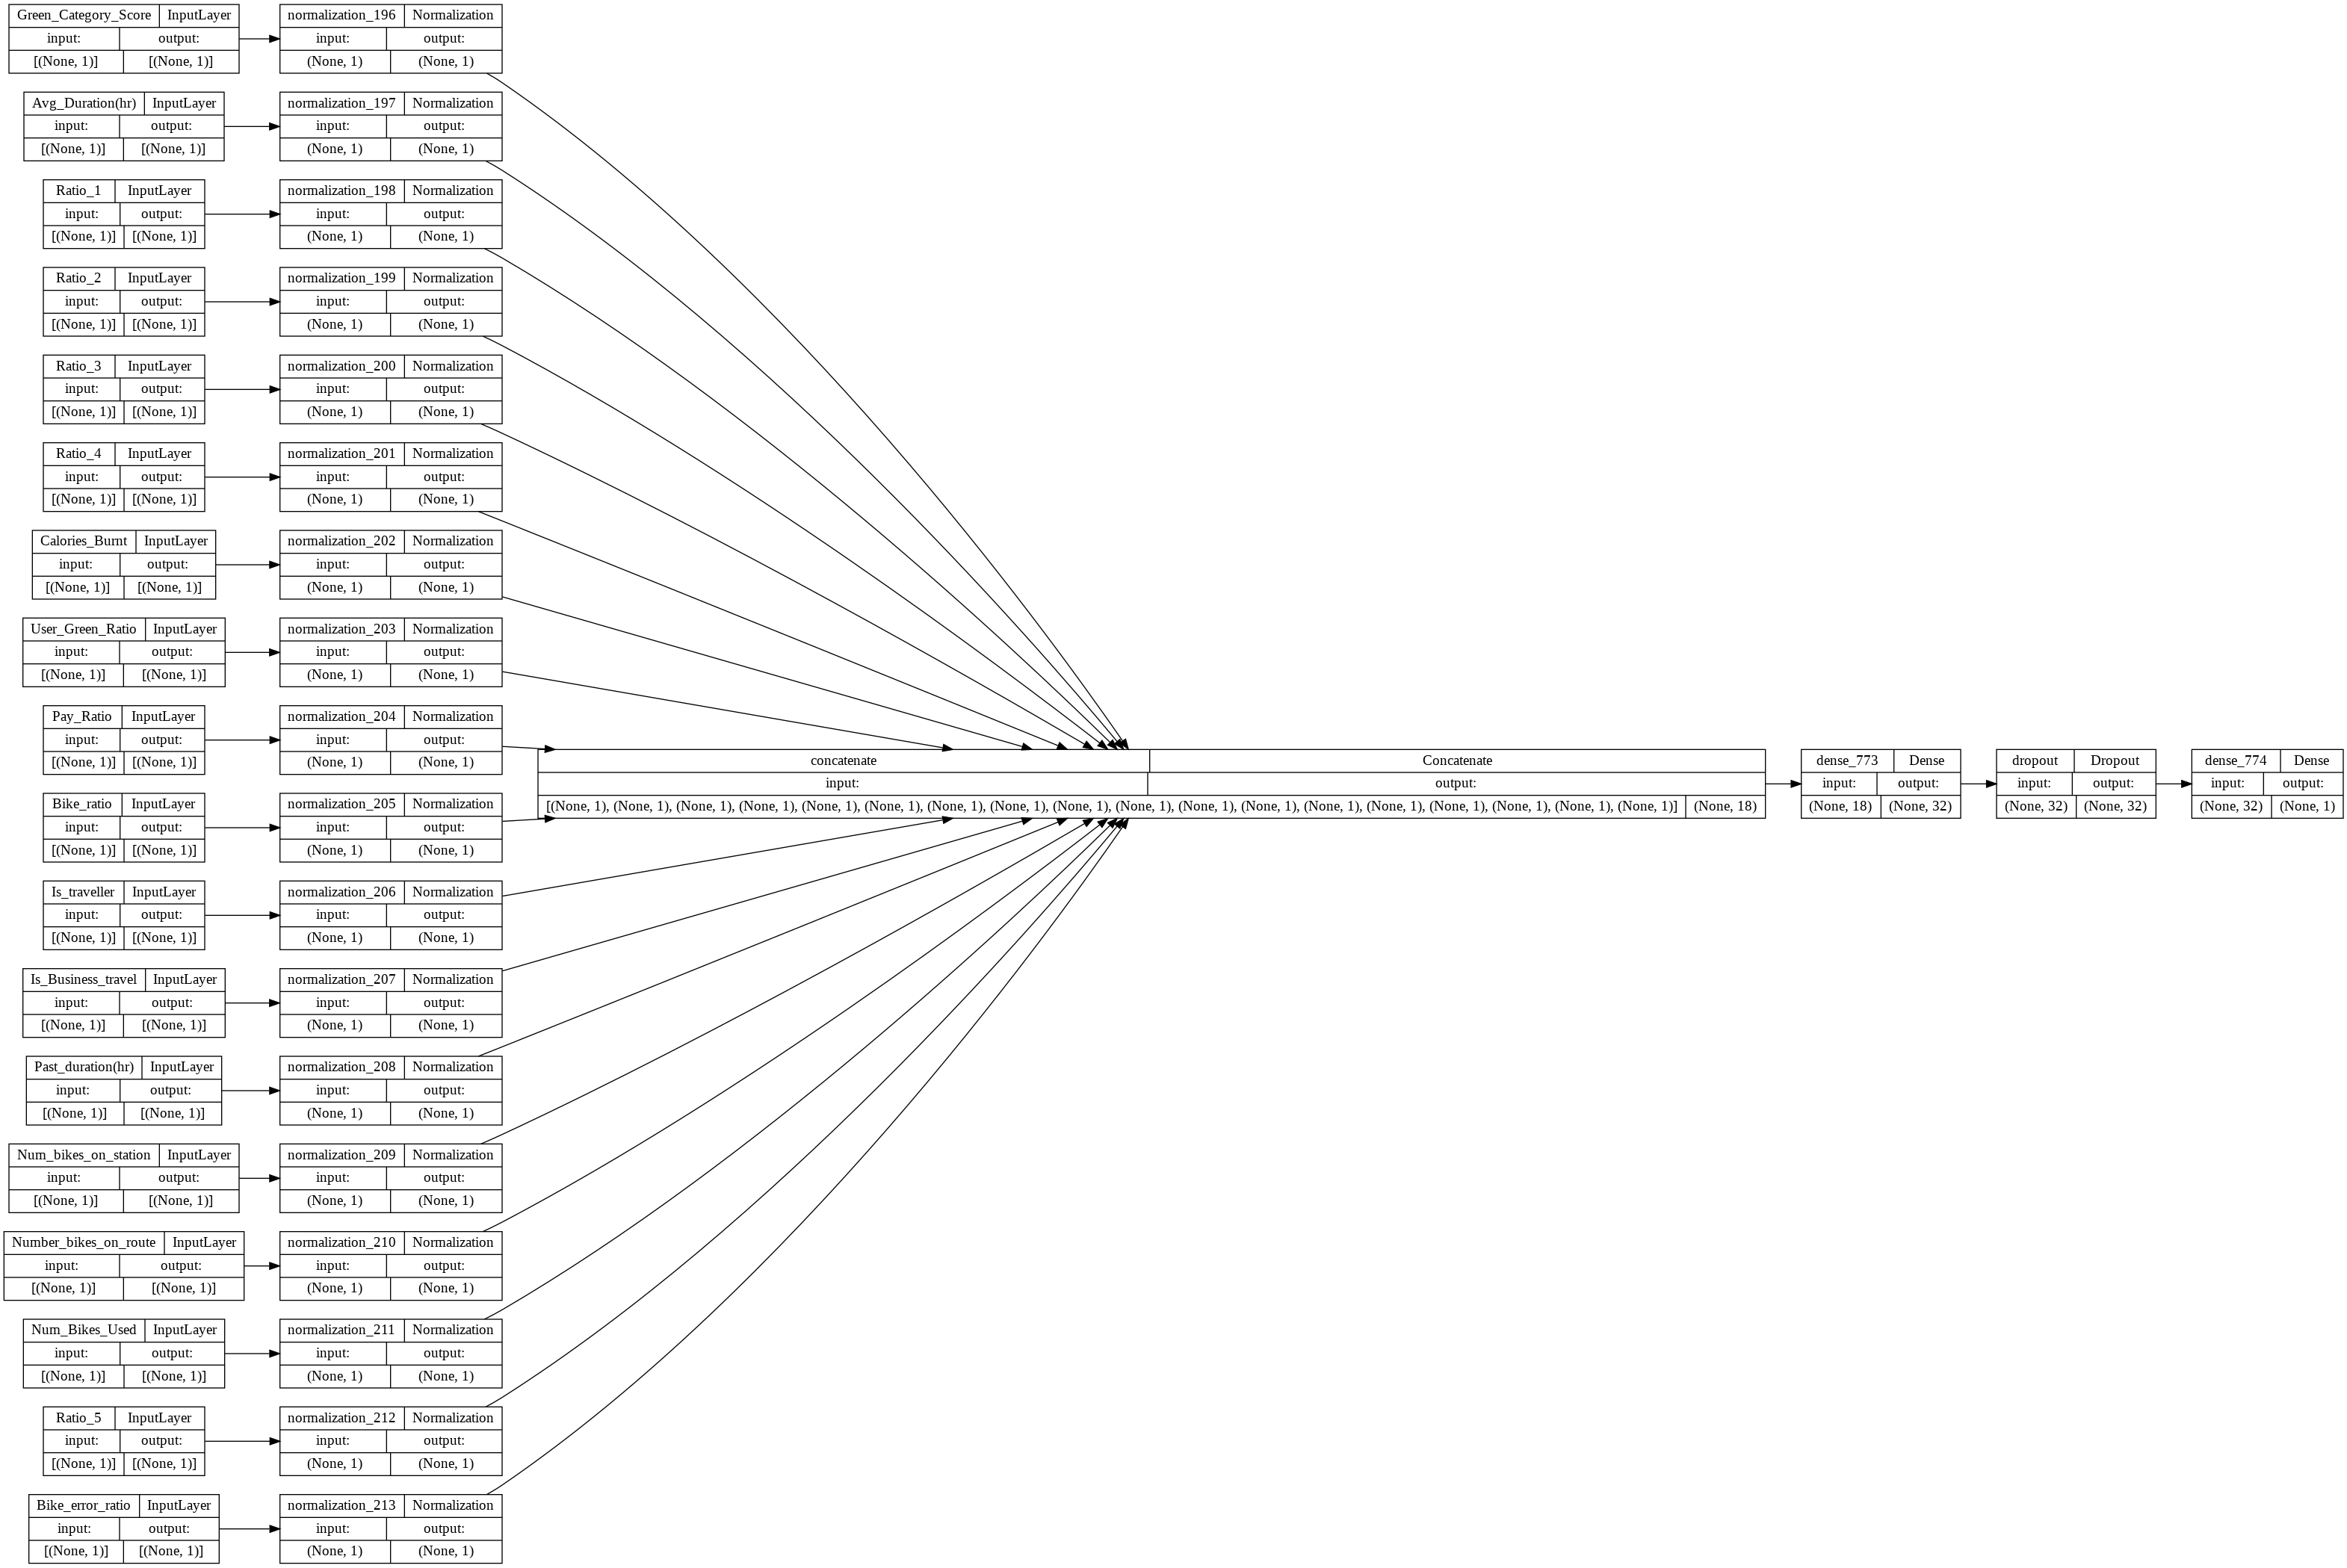

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

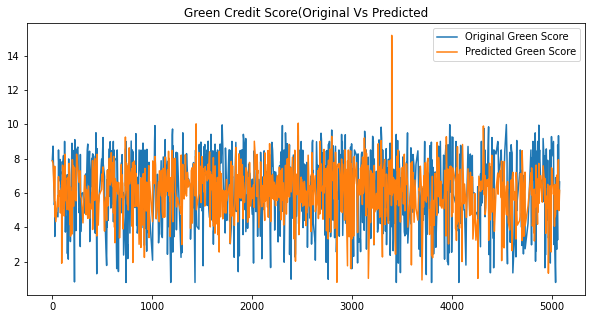

In [ ]:
pd.DataFrame({'Original Green Score':test_labels,
                              'Predicted Green Score':test_predictions}).plot(title='Green Credit Score(Original Vs Predicted',kind='line')

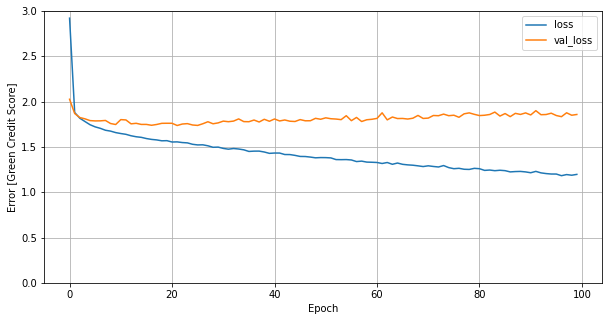

[codecarbon INFO @ 17:44:54] Energy consumed for RAM : 0.010533 kWh. RAM Power : 4.755459308624268 W
[codecarbon INFO @ 17:44:54] Energy consumed for all CPUs : 0.094169 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 17:44:54] 0.104702 kWh of electricity used since the begining.


In [ ]:
plot_loss(history)

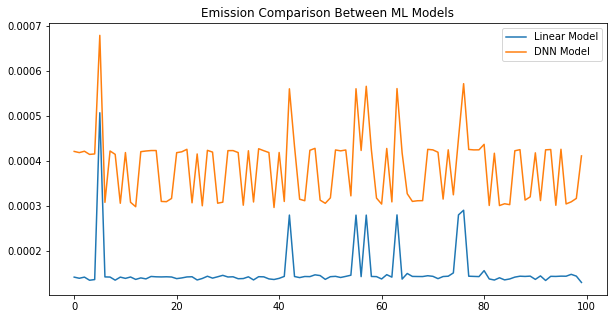

In [ ]:
df = emission_df.copy()
df_data = df.copy()
df_data.to_csv('Emission_data.csv')
df.plot(title = 'Emission Comparison Between ML Models')

In [ ]:
## Classification for the Evergreen User

In [ ]:
dataset = pd.read_csv('/content/Ever_Green_Classification.csv')
dataset = dataset.drop(['User_ID'],axis=1)

In [ ]:
train, val, test = np.split(dataset.sample(frac=1), [int(0.8*len(dataset)), int(0.9*len(dataset))])
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('label')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

train_features = ['Green_Category_Score', 'Avg_Duration(hr)', 'Ratio_1', 'Ratio_2',
       'Ratio_3', 'Ratio_4', 'Calories_Burnt', 'User_Green_Ratio', 'Pay_Ratio',
       'Bike_ratio', 'Is_traveller', 'Is_Business_travel', 'Past_duration(hr)',
       'Num_bikes_on_station', 'Number_bikes_on_route', 'Num_Bikes_Used',
       'Ratio_5', 'Bike_error_ratio']
label_batch = ['label']

all_inputs = []
encoded_features = []

# Numerical features.
for header in train_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
model.fit(train_ds, epochs=10, validation_data=val_ds)

sample = {
    'Green_Category_Score':9.12671,
    'Avg_Duration(hr)': 9.34,
    'Ratio_1': 0.348592,
    'Ratio_2': 0.066901,
    'Ratio_3': 0.026408,
    'Ratio_4': 0.010563,
    'Calories_Burnt': 331.753555,
    'User_Green_Ratio': 0.022104,
    'Pay_Ratio': 0.176944,
    'Bike_ratio': 1.725,
    'Is_traveller': 1,
    'Is_Business_travel': 1,
    'Past_duration(hr)': 0.32,
    'Num_bikes_on_station' : 9709,
    'Number_bikes_on_route' : 568,
    'Num_Bikes_Used' : 8,
    'Ratio_5' : 0.26966,
    'Bike_error_ratio' : 0.088235
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

predictions = model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])


In [ ]:
print(
    "This user has a %.1f percent probability "
    "of becoming evergreen user." % (100 * prob)
)

This user has a 42.4 percent probability of becoming evergreen user.
